## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [74]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [75]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [76]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [77]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [78]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [79]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [80]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [81]:
ind = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index

In [82]:
df2 = df.drop(index = ind)

In [83]:
df2.groupby('group')['landing_page'].value_counts()

group      landing_page
control    old_page        145274
treatment  new_page        145311
Name: landing_page, dtype: int64

In [84]:

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [85]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [86]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [87]:
ind = df2[df2['user_id'].duplicated() == True].index

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [88]:
df2.drop(index = ind , inplace = True )

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [89]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [90]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [91]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [92]:
len(df2.query('landing_page == "new_page"'))/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

- it seems that the conversion rate for the old page (12.04%) is bigger than the conversion rate for the new page (11.88%) but this is not enough to conclude that the old page is better. We need to use Hypothesis testing techniques and conditional probability.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null :             **$p_{new}$** - *$p_{old}$* <= 0

Alternative :      **$p_{new}$** - *$p_{old}$* > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [93]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [94]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [95]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [96]:
n_old = len(df2.query('group == "control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [97]:
# simulating under null for n_new
new_page_converted = np.random.choice([1, 0], size=n_new , p=[p_new, (1 - p_new)])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [98]:
# simulating under null for n_old
old_page_converted = np.random.choice([1, 0], size=n_old , p=[p_old, (1 - p_old)])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [99]:
# Difference for simulated values in e. and f.
new_page_converted.mean() - old_page_converted.mean()

0.0007892738762064061

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [100]:
# 10000 difference values using the binomial distribution in simulation process.
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted 

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

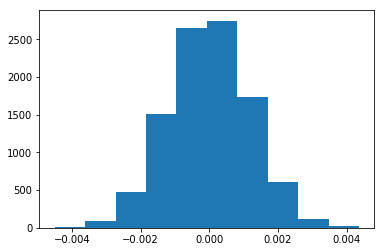

In [101]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [102]:
# the actual difference between treatment and control groups in ab_data
actual_difference = (df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean())
actual_difference

-0.0015782389853555567

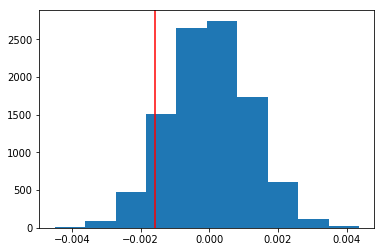

In [103]:
plt.hist(p_diffs);
plt.axvline(x=actual_difference, color='r');

In [104]:
# computing the p-value
(p_diffs > actual_difference).mean()

0.9073

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv is called the p-value

The p-value is the probability of observing the statistic if the null hypothesis is true.

The null hypothesis was that the difference *$p_{new}$ - $p_{old}$* would be <= 0, and the alternative was the difference would be > 0. However, the difference is less than zero, and the p-value is very large. We fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [105]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = len(df2.query('group == "control"'))
n_new = len(df2.query('group == "treatment"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [106]:
stat, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
stat, pval

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- A z-test is a statistical test to determine whether two population means are different when the variances are known and the sample size is large.
- Assume an alpha of 0.05 is selected with a two-tailed test. The critical value is 1.96 or -1.96.
- If the value of z is greater than 1.96 or less than -1.96, the null hypothesis is rejected.

- Our Z score is 1.31, which is less than 1.96 and greater than -1.96. 
- Also the p value is 0.9051, which is greater than alpha 0.05. 

Therefore we fail to reject the null hypothesis. the results agree with what we found in **j. k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [107]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop(columns = 'control').head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [108]:
lm = sm.Logit(df2['converted'] , df2[['intercept', 'ab_page']])
result = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [109]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-17 22:37 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

- the p-value associated with ab_page is 0.1899

- it differs from what I found in part2 because the hypothesis changed to :

**$p_{new}$** - *$p_{old}$*  = 0   (the difference is equal to 0)

**$p_{new}$** - *$p_{old}$* != 0   (the difference is not equal to 0)

and because part III is two sided (two-tailed) test and Part II is a one sided test (one-tailed).

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is good to add other variables that might have an influence on whether an individual converts. It will most likely make our model accuracy greater. But we have to be careful about the issues we might face with these variables as the model gets more complex. the most common issue is multicollinearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [110]:
df3 = pd.read_csv('countries.csv')
df3.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [111]:
df2 = df2.set_index('user_id').join(df3.set_index('user_id'))

In [112]:
df2[['US' , 'UK', 'CA']] = pd.get_dummies(df2['country'])

In [113]:
lm = sm.Logit(df2['converted'] , df2[['intercept', 'US' , 'UK']])
result = lm.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-17 22:37 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
US           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [114]:
np.exp(-0.0408) , np.exp(0.0099)

(0.96002111497165088, 1.0099491671175422)

I have set Canada as baseline. 

The interpretation of the coefficents :
- conversion is 1.01 time likely to happen in UK than in CANADA holding all other variables constant.
- conversion is 0.96 time likely to happen in US than in CANADA holding all other variables constant.

The interpretation of the p-value :
- For the US : the p-value is 0.13, greater than alpha = 0.05 which means it doesn't have a significant relationship with the conversion rate.
- For the UK : the p-value is 0.45, greater than alpha = 0.05 which means it doesn't have a significant relationship with the conversion rate.

The Conclusion :
- We conclude that the variable country does not have a significant relationship with conversion.

 **We fail to reject the null hypothesis**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [119]:
df2['US_new'] = df2['US'] * df2['ab_page']
df2['UK_new'] = df2['UK'] * df2['ab_page']

In [122]:
lm = sm.Logit(df2['converted'] , df2[['intercept', 'US_new' , 'UK_new']])
result = lm.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-17 22:52 AIC:              212779.0384
No. Observations:   290584           BIC:              212810.7773
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
US_new       -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
UK_new        0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

still Canada is baseline. 

The interpretation of the coefficents :
- The interpretations of the coefficents of the US_new and UK_new are hard to define since these variable are higher order terms. 

The interpretation of the p-value :
- For US_new : the p-value is 0.046, slightly less than alpha = 0.05 which means it might have a significant relationship with the conversion rate.
- For UK_new : the p-value is 0.389, greater than alpha = 0.05 which means it doesn't have a significant relationship with the conversion rate.

The Conclusion :
- We conclude that the variable US_new and UK_new does not have a significant relationship with conversion.

 **We fail to reject the null hypothesis**

<a id='conclusions'></a>
## Conclusion

practical reasoning : The null hypothesis stated that the old page conversions are equal or higher than the conversions in the new page. 
since we fail to reject the null hypothesis, this means it is true that the old page is doing better. practically, the best decision is to stick with the old page and not change to the new one.

In [123]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0